# Table of Contents
 <p><div class="lev1"><a href="#Introduction"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2"><a href="#Collected-data"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Collected data</a></div><div class="lev2"><a href="#Collected-data"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collected data</a></div><div class="lev2"><a href="#Latency"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Latency</a></div>

# Introduction

The objective of this analysis is to study the distribution of network jitter in Tor entry guards. Some nodes might have a significantly large jitter than the average. We believe that in those cases, website fingerprinting may have lower effectiveness than in the entry guards with low jitter. The rationale is that even if the entry to guard TCP connection is independent of the website, the interaction between the page structure (HTTP request/response pattern) and the jitter, may make the fingerprint less reliable than in low-jitter guards.

In [2]:
%matplotlib inline
from os import listdir
from os.path import join, dirname, realpath, isdir, getmtime
from glob import glob

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell

# Notebook config
InteractiveShell.ast_node_interactivity = "all"

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [16]:
# button to toggle code

HTML('''<script>
code_show=true; 
function code_toggle() {
 document.title = 'Variance analysis';
 code_show = !code_show
 var divs = document.getElementsByClassName('input');
 var divs = document.getElementsByClassName('input');
 if (code_show){
   for (var i in divs) {
     if (typeof divs[i] != 'undefined') {
       divs[i].style.display = 'block';
     } 
   }
 } else {
   for (var i in divs) {
     if (typeof divs[i] != 'undefined') {
       divs[i].style.display = 'none';
     } 
   }
 }
} 

document.addEventListener("DOMContentLoaded", function(event) { 
  code_toggle()
});
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
# directories
BASE_DIR = dirname(realpath("__file__"))
RESULTS_DIR = join(BASE_DIR, 'results')
LATEST_DIR = max([join(RESULTS_DIR, d) for d in listdir(RESULTS_DIR)
                  if isdir(join(RESULTS_DIR, d))], key=getmtime)

# globals
CSV_NAMES = ["ip_proto", "epoch",
             "ip_src", "ip_dst", "port_src", "port_dst",
             "ip_len", "ip_hdr_len", "tcp_hdr_len", "data_len",
             "tcp_flags", "tcp_seq", "tcp_ack",
             "tcp_window_size_value", "ws_message",
             "tcp_options_tsval", "tcp_options_tsecr"]

In [4]:
# get filenames
stat_files = {}
for fname in listdir(LATEST_DIR):
    if fname not in stat_files:
        key = fname.split('_')[0]
        stat_files[key] = glob(join(LATEST_DIR, key + '*'))

guards = len(stat_files)
avg_samples = np.mean([len(l) for l in stat_files.itervalues()])

## Collected data

We have collected:

In [8]:
print "- Data for", guards, "entry guards"
print "- An average of", int(avg_samples), "samples for each entry guard."

- Data for 520 entry guards
- An average of 1 samples for each entry guard.


This is how the dataset looks like:

In [5]:
# load data in a dataframe
dfs = []
for k, l in stat_files.iteritems():
    for i, fpath in enumerate(l):
        df = pd.read_csv(fpath, names=CSV_NAMES)
        df = df[(df['tcp_flags'] == '0x0002') | (df['tcp_flags'] == '0x0012')]  # SYN and SYN,ACK packets
        df['entry'] = k
        df['sample'] = i
        dfs.append(df)
data = pd.concat(dfs)
data[['entry', 'sample'] + [c for c in data.columns if c != 'entry' and c != 'sample']].head()

,entry,sample,ip_proto,epoch,ip_src,ip_dst,port_src,port_dst,ip_len,ip_hdr_len,tcp_hdr_len,data_len,tcp_flags,tcp_seq,tcp_ack,tcp_window_size_value,ws_message,tcp_options_tsval,tcp_options_tsecr,sample
0,0882440874034AFBE2FBF16463A290F3278E24F7,0,6.0,1.485698e+09,172.17.0.2,176.58.121.159,59798.0,9001.0,60.0,20.0,40.0,NaN,0x0002,0.0,NaN,29200.0,NaN,1674606.0,0.0,0
1,0882440874034AFBE2FBF16463A290F3278E24F7,0,6.0,1.485698e+09,176.58.121.159,172.17.0.2,9001.0,59798.0,48.0,20.0,28.0,NaN,0x0012,0.0,1.0,65535.0,NaN,NaN,NaN,0
0,02C2FFF7DF14A396FAFA828443561DAA08EB8DC0,0,6.0,1.485697e+09,172.17.0.2,163.44.112.230,52786.0,9001.0,60.0,20.0,40.0,NaN,0x0002,0.0,NaN,29200.0,NaN,1613906.0,0.0,0
1,02C2FFF7DF14A396FAFA828443561DAA08EB8DC0,0,6.0,1.485697e+09,163.44.112.230,172.17.0.2,9001.0,52786.0,48.0,20.0,28.0,NaN,0x0012,0.0,1.0,65535.0,NaN,NaN,NaN,0
0,1D3F937E2053E58C18E18D43FA5153E2A9F4DC77,0,6.0,1.485700e+09,172.17.0.2,139.59.172.93,56678.0,443.0,60.0,20.0,40.0,NaN,0x0002,0.0,NaN,29200.0,NaN,1901008.0,0.0,0


## Latency

We compute the latency by extracting the SYN, SYN-ACK packets of the TCP connection for the Tor circuit to each entry. We substract the SYN-ACK timestamp to the SYN timestamp to obtain the latency to that specific entry.

This is the dataset of latencies:

In [20]:
def latencies(data):
    """Compute latencies for all samples in the dataframe."""
    def ts(d):
        if len(d) >=2:
            return np.diff(d['epoch'])[0]
        return np.nan
    return data.groupby(['entry', 'sample']).apply(ts).reset_index(name='latency')

def jitter(latencies):
    """Compute jitter for latency data."""
    return latencies['latency']

In [21]:
lats = latencies(data).dropna()
lats.head()

,entry,sample,latency
3,00943662F30ECE7AA2D1262B364FC0431F78F80C,0,0.119213
4,00AD0313351C07411F44C0A78FC54C3EBAE23265,0,0.132808
5,00E64ADF25DCB86A98C77994E3D281583BE21E32,0,0.040932
6,00FCEEEE1DDD04C94A2AEFFC654242813C5C84BB,0,0.051303
7,010B7728454411F485CE29D4C79A14534151C2C4,0,0.061086


We extract some basic statistics about the latencies:

In [27]:
lats.describe()

,sample,latency
count,229.0,229.000000
mean,0.0,0.072303
std,0.0,0.120728
min,0.0,0.015577
25%,0.0,0.029334
50%,0.0,0.039045
75%,0.0,0.073639
max,0.0,1.071593


We plot the histogram of latencies:

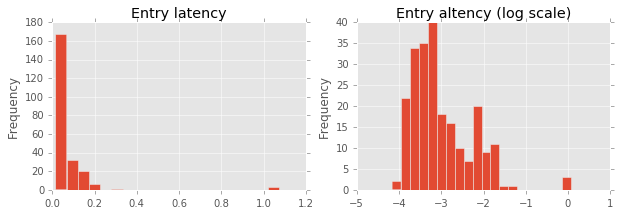

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
lats['latency'].plot(kind='hist', bins=20, ax=ax1, figsize=(10, 3), title="Entry latency")
lats['latency'].apply(np.log).plot(kind='hist', bins=20, ax=ax2, figsize=(10, 3), title="Entry altency (log scale)")